In [1]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [2]:
import pandas as pd

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
from embedding_adapter.embedding_model import EmbeddingModel

# Load sentence embedding model
model = EmbeddingModel(device_map='cuda', model_name="e5")

/home/ec2-user/embedding-adapter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from embedding_adapter.products_module import TripletModule
import torch

# Load the sentence adapter from the checkpoint
checkpoint_path = f"logs/products/triplet_model_2025-05-15_11-46-03_503b0c/checkpoints/triplet-model-best-ood-val.ckpt"
adapter_model = TripletModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
adapter_model.eval()
dtype = adapter_model.dtype
adapter = adapter_model.adapter

In [6]:
attributes = ['color', 'brand', 'material', 'size', 'weight']
dfs = {}
for attribute in attributes:
    # Load the dataset
    print(f"Loading dataset for attribute: {attribute}")
    dfs[attribute] = pd.read_csv(f"raw_data/amazon/amazon_{attribute}.csv")

Loading dataset for attribute: color
Loading dataset for attribute: brand
Loading dataset for attribute: material
Loading dataset for attribute: size
Loading dataset for attribute: weight


In [7]:
# Preprocessing loop
processed_data = {}
for key in attributes:
    # Get the text and true labels
    df = dfs[key]
    mask = ~pd.isna(df[key])
    df_xp = df[mask].copy()

    # Convert to string to ensure consistency
    df_xp['label'] = df_xp[key].astype(str)

    # Extract text and true labels
    text = df_xp['text'].astype(str)
    true_labels = df_xp['label']

    print(f'Preparing data for key: {key}')
    print(f'Unique labels (balanced): {true_labels.unique()}')
    print(f'Number of samples: {len(text)}')

    processed_data[key] = {'text': text, 'true_labels': true_labels}

Preparing data for key: color
Unique labels (balanced): ['red' 'blue' 'green' 'black' 'white' 'yellow' 'purple' 'pink' 'orange'
 'grey' 'brown']
Number of samples: 151
Preparing data for key: brand
Unique labels (balanced): ['adidas' 'nike' 'reebok' 'skechers']
Number of samples: 80
Preparing data for key: material
Unique labels (balanced): ['cotton' 'fabric' 'polyester']
Number of samples: 60
Preparing data for key: size
Unique labels (balanced): ['20oz' '30oz' '40oz']
Number of samples: 60
Preparing data for key: weight
Unique labels (balanced): ['16 lb' '22 lb' '3 lb' '5 lb']
Number of samples: 52


In [8]:
INSTRUCTIONS = {
    'color': "Identify the color of the product.",
    'material': "Identify the material of the given product.",
    'brand': "Identify the brand of the product.",
    'size': "Identify the volume of the given bottle.",
    'weight': "Identify the weight and size of the given cat food.",
}

In [9]:
from torch.nn import functional as F

# Encoding loop
embeddings_data = {}
for key, data in processed_data.items():
    print(f'Encoding text for key: {key}')
    text_embeddings = model.encode(data['text'].tolist(), batch_size=32, max_length=512).to(dtype)

    # adapt the embeddings using the instruction
    instruction_embedding = model.encode([INSTRUCTIONS[key]], batch_size=1, max_length=512).to(dtype)
    instruction_embedding = instruction_embedding.expand(text_embeddings.size(0), -1)
    adapted_embeddings = adapter.encode(text_embeddings, instruction_embedding).detach()
    
    embeddings_data[key] = {
        'text_embeddings': text_embeddings.cpu().numpy(), 
        'adapted_embeddings': adapted_embeddings.cpu().numpy(),
        'true_labels': data['true_labels']
    }

Encoding text for key: color


Processing batches: 100%|██████████| 1/1 [00:00<00:00, 47.31it/s]


Encoding text for key: brand


Processing batches: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s]


Encoding text for key: material


Processing batches: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Encoding text for key: size


Processing batches: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


Encoding text for key: weight


Processing batches: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


### Vanilla Embeddings

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

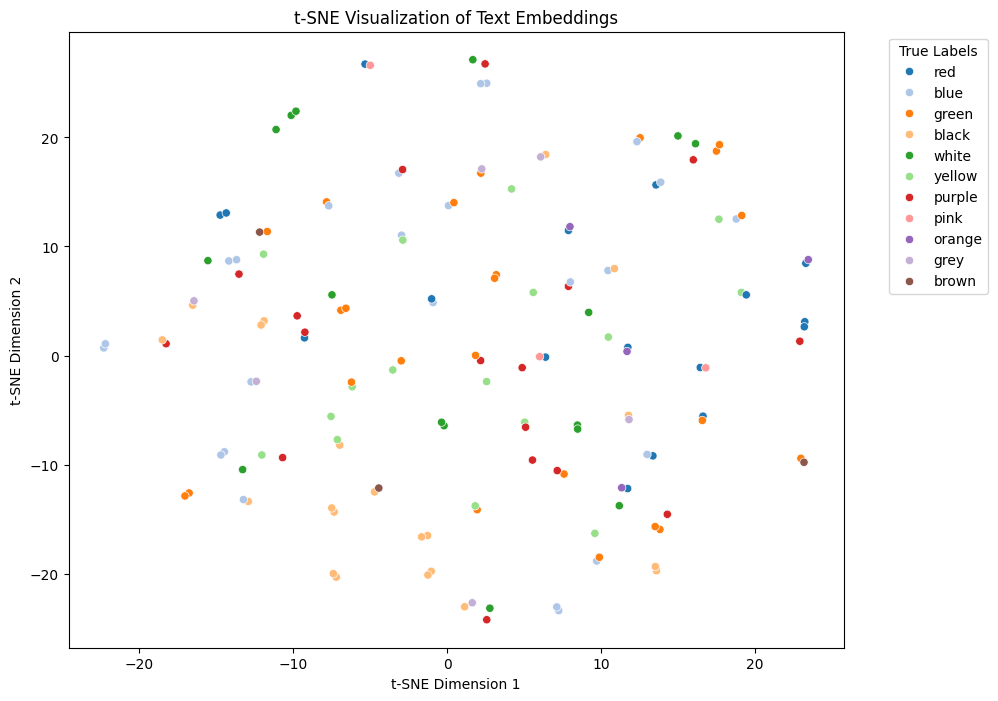

In [11]:
feature_data = embeddings_data[attributes[0]]
text_embeddings = feature_data['text_embeddings']
labels = feature_data['true_labels']

# Perform t-SNE on the adapted embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_results = tsne.fit_transform(text_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("tab20", len(labels.unique())),
    legend="full"
)
plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [12]:
# Evaluation loop
for key, data in embeddings_data.items():
    print(f'Evaluating clustering for key: {key}')
    embeddings = data['text_embeddings']
    true_labels = data['true_labels']

    # Perform unsupervised clustering
    n_clusters = 11
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(true_labels, cluster_labels)

    # Normalized Mutual Information (NMI)
    nmi_score = normalized_mutual_info_score(true_labels, cluster_labels, average_method='arithmetic')

    print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
    print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')
    print('---')

Evaluating clustering for key: color
Adjusted Rand Index (ARI): 0.0309
Normalized Mutual Information (NMI): 0.1783
---
Evaluating clustering for key: brand
Adjusted Rand Index (ARI): 0.2769
Normalized Mutual Information (NMI): 0.4650
---
Evaluating clustering for key: material
Adjusted Rand Index (ARI): 0.1566
Normalized Mutual Information (NMI): 0.3802
---
Evaluating clustering for key: size
Adjusted Rand Index (ARI): 0.1149
Normalized Mutual Information (NMI): 0.3062
---
Evaluating clustering for key: weight
Adjusted Rand Index (ARI): 0.0287
Normalized Mutual Information (NMI): 0.2342
---


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Evaluation loop
for key, data in embeddings_data.items():
    print(f'Evaluating reranking for key: {key}')
    embeddings = data['text_embeddings']
    true_labels = data['true_labels']

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Initialize variables to compute precision
    precisions = []

    TOPK = 10

    # Iterate over each item as the target
    for i in range(len(true_labels)):
        # Get the similarity scores for the target item
        similarities = similarity_matrix[i]
        
        # Rank items based on similarity (excluding the target itself)
        ranked_indices = np.argsort(similarities)[::-1]
        ranked_indices = ranked_indices[ranked_indices != i]
        
        # Get the top most similar items
        topk_indices = ranked_indices[:TOPK]
        
        # Compute precision: check how many of the top-k items have the same label
        target_label = true_labels.iloc[i]
        topk_labels = true_labels.iloc[topk_indices]

        precision = (topk_labels == target_label).mean()
        precisions.append(precision)

    # Compute the average precision at top-k
    precisions = np.mean(precisions)
    print(f"Average Same-Label precision at Top-k: {precisions:.4f}")

Evaluating reranking for key: color
Average Same-Label precision at Top-k: 0.3331
Evaluating reranking for key: brand
Average Same-Label precision at Top-k: 0.6550
Evaluating reranking for key: material
Average Same-Label precision at Top-k: 0.5967
Evaluating reranking for key: size
Average Same-Label precision at Top-k: 0.5500
Evaluating reranking for key: weight
Average Same-Label precision at Top-k: 0.3481


### Adapted Embeddings

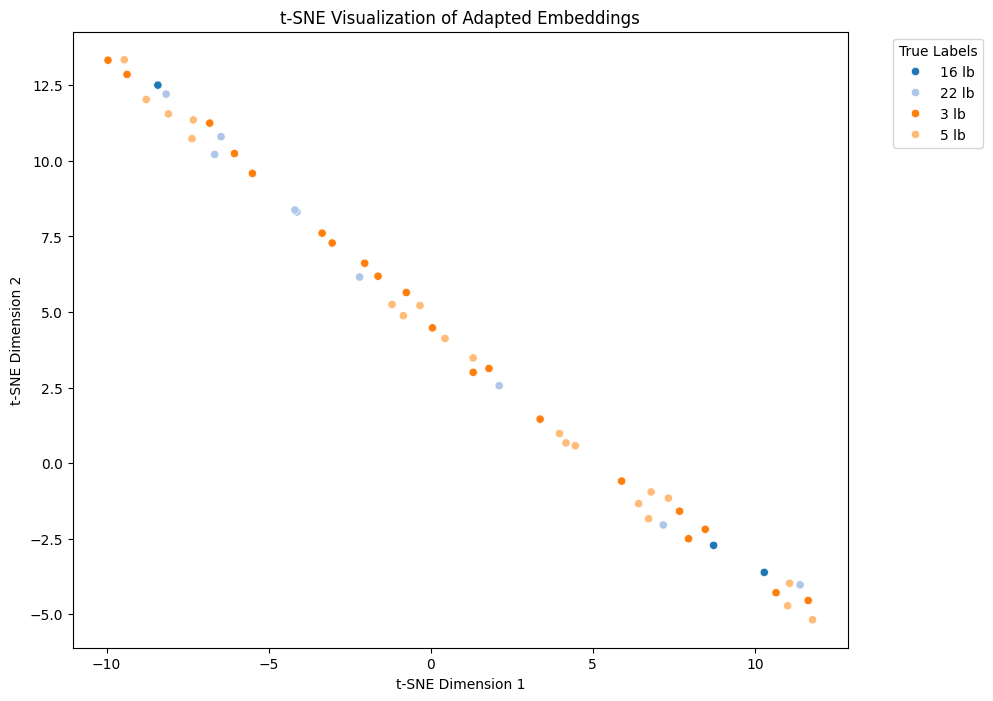

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

feature_data = embeddings_data[attribute]
adapted_embeddings = feature_data['adapted_embeddings']
labels = feature_data['true_labels']

# Perform t-SNE on the adapted embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_results = tsne.fit_transform(adapted_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("tab20", len(labels.unique())),
    legend="full"
)
plt.title("t-SNE Visualization of Adapted Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [15]:
# Evaluation loop
for key, data in embeddings_data.items():
    print(f'Evaluating clustering for key: {key}')
    embeddings = data['adapted_embeddings']
    true_labels = data['true_labels']

    # Perform unsupervised clustering
    n_clusters = 11
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(true_labels, cluster_labels)

    # Normalized Mutual Information (NMI)
    nmi_score = normalized_mutual_info_score(true_labels, cluster_labels, average_method='arithmetic')

    print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
    print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')
    print('---')

Evaluating clustering for key: color
Adjusted Rand Index (ARI): 0.0105
Normalized Mutual Information (NMI): 0.1761
---
Evaluating clustering for key: brand
Adjusted Rand Index (ARI): 0.0793
Normalized Mutual Information (NMI): 0.2535
---
Evaluating clustering for key: material
Adjusted Rand Index (ARI): 0.0549
Normalized Mutual Information (NMI): 0.1741
---
Evaluating clustering for key: size
Adjusted Rand Index (ARI): 0.0006
Normalized Mutual Information (NMI): 0.1117
---
Evaluating clustering for key: weight
Adjusted Rand Index (ARI): -0.0131
Normalized Mutual Information (NMI): 0.1725
---


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Evaluation loop
for key, data in embeddings_data.items():
    print(f'Evaluating reranking for key: {key}')
    embeddings = data['adapted_embeddings']
    true_labels = data['true_labels']

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Initialize variables to compute precision
    precisions = []

    TOPK = 10

    # Iterate over each item as the target
    for i in range(len(true_labels)):
        # Get the similarity scores for the target item
        similarities = similarity_matrix[i]
        
        # Rank items based on similarity (excluding the target itself)
        ranked_indices = np.argsort(similarities)[::-1]
        ranked_indices = ranked_indices[ranked_indices != i]
        
        # Get the top most similar items
        topk_indices = ranked_indices[:TOPK]
        
        # Compute precision: check how many of the top-k items have the same label
        target_label = true_labels.iloc[i]
        topk_labels = true_labels.iloc[topk_indices]

        precision = (topk_labels == target_label).mean()
        precisions.append(precision)

    # Compute the average precision at top-k
    precisions = np.mean(precisions)
    print(f"Average Same-Label precision at Top-k: {precisions:.4f}")

Evaluating reranking for key: color
Average Same-Label precision at Top-k: 0.1795
Evaluating reranking for key: brand
Average Same-Label precision at Top-k: 0.3138
Evaluating reranking for key: material
Average Same-Label precision at Top-k: 0.3750
Evaluating reranking for key: size
Average Same-Label precision at Top-k: 0.3217
Evaluating reranking for key: weight
Average Same-Label precision at Top-k: 0.2885
